In [1]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
from shapely.geometry import Point
from sklearn.model_selection import train_test_split

In [2]:
nyc = gpd.read_file('../data/Neighborhood Tabulation Areas.geojson')

In [3]:
nyc.head()

,ntacode,shape_area,county_fips,ntaname,shape_leng,boro_name,boro_code,geometry
0,BK88,54005018.7472,047,Borough Park,39247.2280737,Brooklyn,3,"MULTIPOLYGON (((-73.97605 40.63128, -73.97717 ..."
1,QN51,52488276.477,081,Murray Hill,33266.904811,Queens,4,"MULTIPOLYGON (((-73.80379 40.77561, -73.80099 ..."
2,QN27,19726845.26,081,East Elmhurst,19816.7115378,Queens,4,"MULTIPOLYGON (((-73.86110 40.76366, -73.85993 ..."
3,QN07,22887772.7683,081,Hollis,20976.3358374,Queens,4,"MULTIPOLYGON (((-73.75726 40.71814, -73.75589 ..."
4,MN06,10647077.6122,061,Manhattanville,17040.6865482,Manhattan,1,"MULTIPOLYGON (((-73.94608 40.82126, -73.94640 ..."


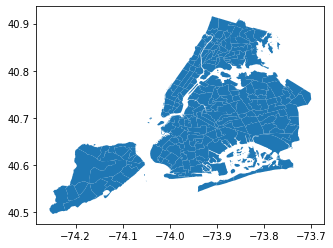

In [4]:
nyc.plot()

In [5]:
data = pd.read_csv('../data/train.csv')

In [6]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [7]:
indices = np.arange(len(data))

In [8]:
def get_ntacode(idx):
    row = data.iloc[idx]
    pickup_point = Point((row.pickup_longitude, row.pickup_latitude))
    dropoff_point = Point((row.dropoff_longitude, row.dropoff_latitude))
    
    pickup_ntacode = np.nan
    dropoff_ntacode = np.nan
    
    for ntacode, geom in zip(nyc.ntacode, nyc.geometry):
        if pickup_point.within(geom):
            pickup_ntacode = ntacode
            break

    
    for ntacode, geom in zip(nyc.ntacode, nyc.geometry):
        if dropoff_point.within(geom):
            dropoff_ntacode = ntacode
            break

    return (pickup_ntacode, dropoff_ntacode)
    

In [9]:
%%time
with Pool(cpu_count()) as pool:
    ntacodes = list(pool.map(get_ntacode, indices))

CPU times: user 7.58 s, sys: 265 ms, total: 7.85 s
Wall time: 22min 39s


In [10]:
nta = pd.DataFrame(data=ntacodes, columns=['pickup_ntacode', 'dropoff_ntacode'])

In [11]:
data = data.join(nta)

In [12]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_ntacode,dropoff_ntacode
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,MN14,MN40
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,MN20,MN23
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,MN17,MN25
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,MN24,MN25
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,MN12,MN12


In [15]:
data = pd.merge(data, nyc[['ntacode', 'boro_name']], left_on='pickup_ntacode', right_on='ntacode', how='left')
data = data.rename(columns={'boro_name': 'pickup_neighborhood'}).drop('ntacode', axis=1)
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_ntacode,dropoff_ntacode,pickup_neighborhood
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,MN14,MN40,Manhattan
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,MN20,MN23,Manhattan
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,MN17,MN25,Manhattan
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,MN24,MN25,Manhattan
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,MN12,MN12,Manhattan


In [17]:
data = pd.merge(data, nyc[['ntacode', 'boro_name']], left_on='dropoff_ntacode', right_on='ntacode', how='left')
data = data.rename(columns={'boro_name': 'dropoff_neighborhood'}).drop('ntacode', axis=1)
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_ntacode,dropoff_ntacode,pickup_neighborhood,dropoff_neighborhood
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,MN14,MN40,Manhattan,Manhattan
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,MN20,MN23,Manhattan,Manhattan
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,MN17,MN25,Manhattan,Manhattan
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,MN24,MN25,Manhattan,Manhattan
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,MN12,MN12,Manhattan,Manhattan


In [18]:
data.to_csv('../data/nyc_taxi_with_location.csv', index=False)

In [19]:
data.isnull().mean()

id                      0.000000
vendor_id               0.000000
pickup_datetime         0.000000
dropoff_datetime        0.000000
passenger_count         0.000000
pickup_longitude        0.000000
pickup_latitude         0.000000
dropoff_longitude       0.000000
dropoff_latitude        0.000000
store_and_fwd_flag      0.000000
trip_duration           0.000000
pickup_ntacode          0.000838
dropoff_ntacode         0.004341
pickup_neighborhood     0.000838
dropoff_neighborhood    0.004341
dtype: float64

In [20]:
data = data.dropna()

In [21]:
data  = data.iloc[::10]

In [22]:
train, test = train_test_split(data, test_size=0.2, random_state=1)

In [23]:
train.to_csv('../data/prepared_train.csv', index=False)
test.to_csv('../data/prepared_test.csv', index=False)